In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as plotly
import plotly.express as px
plotly.offline.init_notebook_mode()

from sklearn.model_selection import train_test_split


# Data Processing Tasks

In [318]:
# Load the data
df = pd.read_csv('housing_dataset.csv')

In [319]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0    -122.74     39.71                16.0        255.0            73.0  \
1    -117.02     36.40                19.0        619.0           239.0   
2    -117.86     34.24                52.0        803.0           267.0   
3    -123.17     40.31                36.0         98.0            28.0   
4    -118.33     34.15                39.0        493.0           168.0   

   population  households  median_income  median_house_value ocean_proximity  
0        85.0        38.0         1.6607             14999.0          INLAND  
1       490.0       164.0         2.1000             14999.0          INLAND  
2       628.0       225.0         4.1932             14999.0          INLAND  
3        18.0         8.0         0.5360             14999.0          INLAND  
4       259.0       138.0         2.3667             17500.0       <1H OCEAN

## Detect and handle outliers for the “median_house_value” field

### Apply the whiskers approach to identify outlier rows. 

In [320]:
def calculate_outliers(df):
    cols = ['median_house_value']
    outliers_rows = []
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f'Number of outliers in {col}: {len(outliers)}, Percentage of outliers: {len(outliers) / len(df) * 100:.2f}%')
        outliers_rows.extend(outliers.index.tolist())
    
    # Get unique row indices with outliers
    outliers_rows = list(set(outliers_rows))

    # Create boolean array indicating which rows have at least one outlier
    outliers_bool = df.index.isin(outliers_rows)
    
    return outliers_bool

In [321]:
whisker_outliers = calculate_outliers(df)

Number of outliers in median_house_value: 1072, Percentage of outliers: 5.19%


Now to remove the outliers.

In [322]:
no_outliers_df = df[~whisker_outliers]
no_outliers_df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0        -122.74     39.71                16.0        255.0            73.0  \
1        -117.02     36.40                19.0        619.0           239.0   
2        -117.86     34.24                52.0        803.0           267.0   
3        -123.17     40.31                36.0         98.0            28.0   
4        -118.33     34.15                39.0        493.0           168.0   
...          ...       ...                 ...          ...             ...   
19563    -117.68     33.51                19.0       2930.0           428.0   
19564    -122.32     37.52                17.0       6645.0          1034.0   
19565    -118.15     33.84                29.0       2448.0           354.0   
19566    -118.40     33.89                36.0       2334.0           430.0   
19567    -117.78     33.78                 6.0       9792.0          1283.0   

       population  households  median_income  median_house_value   
0            85.0        38.0         1.6607             14999.0  \
1           490.0       164.0         2.1000             14999.0   
2           628.0       225.0         4.1932             14999.0   
3            18.0         8.0         0.5360             14999.0   
4           259.0       138.0         2.3667             17500.0   
...           ...         ...            ...                 ...   
19563      1481.0       430.0         6.3230            480800.0   
19564      2557.0      1032.0         6.3892            480800.0   
19565       894.0       349.0         7.6526            481300.0   
19566      1033.0       407.0         6.6321            481500.0   
19567      3744.0      1179.0        10.1714            481500.0   

      ocean_proximity  
0              INLAND  
1              INLAND  
2              INLAND  
3              INLAND  
4           <1H OCEAN  
...               ...  
19563       <1H OCEAN  
19564      NEAR OCEAN  
19565       <1H OCEAN  
19566       <1H OCEAN  
19567       <1H OCEAN  

[19568 rows x 10 columns]

### Apply Z-score normalization and choose appropriate threshold to match the outliers from the whiskers approach

In [323]:
df_zscore = df.copy()

In [324]:
#check missing values in median_house_value
missing_values = df_zscore['median_house_value'].isnull().sum()
missing_values

80

We will not be able to do the z-score normalization since we have some null values in the column. For the sake of this demonstration, I will replace all null values with a 0, just so we can proceed. 

In [325]:
df_zscore['median_house_value'].fillna(0, inplace=True)

In [326]:
#check missing values in median_house_value
missing_values = df_zscore['median_house_value'].isnull().sum()
missing_values

0

In [327]:
from scipy.stats import zscore

df_zscore['median_house_value_zscore'] = zscore(df_zscore['median_house_value'])

threshold = 2.5
outliers_zscore = df_zscore[(df_zscore['median_house_value_zscore'] > threshold) | (df_zscore['median_house_value_zscore'] < -threshold)]


# print the number of outliers and what percentage of the data they represent
print(f'Number of outliers: {len(outliers_zscore)}, Percentage of outliers: {len(outliers_zscore) / len(df_zscore) * 100:.2f}%')

Number of outliers: 1002, Percentage of outliers: 4.85%


A threshold of `2.5` gave us `1002` outliers, which is relatively close to the `1072` from the whiskers approach. We could have gotten closer with a more "decimal" number but `2.5` seems like enough.

In [328]:
from scipy.stats import zscore

df_zscore['median_house_value_zscore'] = zscore(df_zscore['median_house_value'])

threshold = 2.379
outliers_zscore = df_zscore[(df_zscore['median_house_value_zscore'] > threshold) | (df_zscore['median_house_value_zscore'] < -threshold)]


# print the number of outliers and what percentage of the data they represent
print(f'Number of outliers: {len(outliers_zscore)}, Percentage of outliers: {len(outliers_zscore) / len(df_zscore) * 100:.2f}%')

Number of outliers: 1072, Percentage of outliers: 5.19%


A threshold of `2.379` does it actually.

##  Handle missing values in the dataset

In [329]:
df = no_outliers_df

We have to handle categorical and numerical features differently.

In [330]:
# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numerical features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical features: ['ocean_proximity']


### For numerical features:

In [331]:
numerical_missing_values = df[numerical_features].isnull().sum()
numerical_missing_values

longitude               0
latitude                0
housing_median_age     11
total_rooms            15
total_bedrooms        200
population             19
households             14
median_income           8
median_house_value     80
dtype: int64

**Choose whether mean/median is better to impute the values**

To decide whether to use the mean or median for imputation, I will consider the distribution of each numerical feature with missing values. A skewed distribution suggests using the median, while a normal distribution suggests the mean could be appropriate.

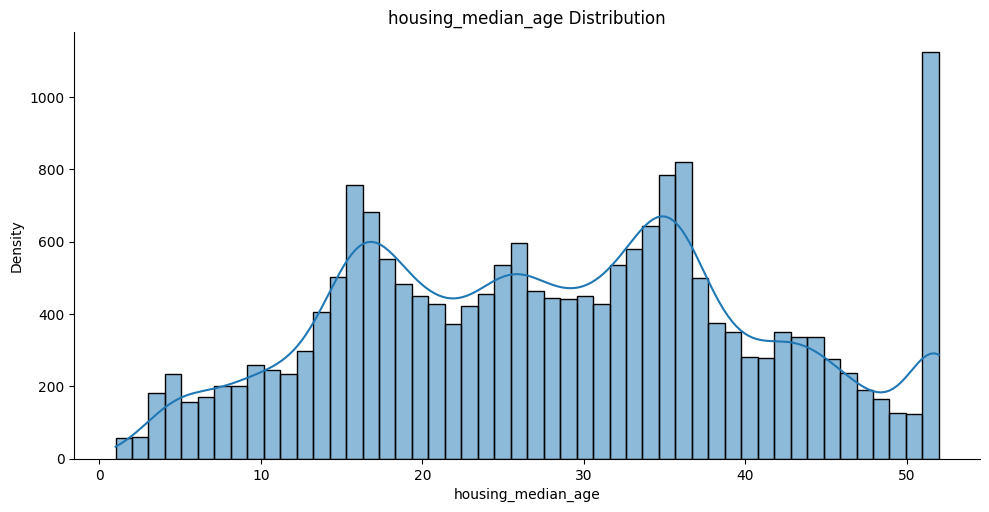

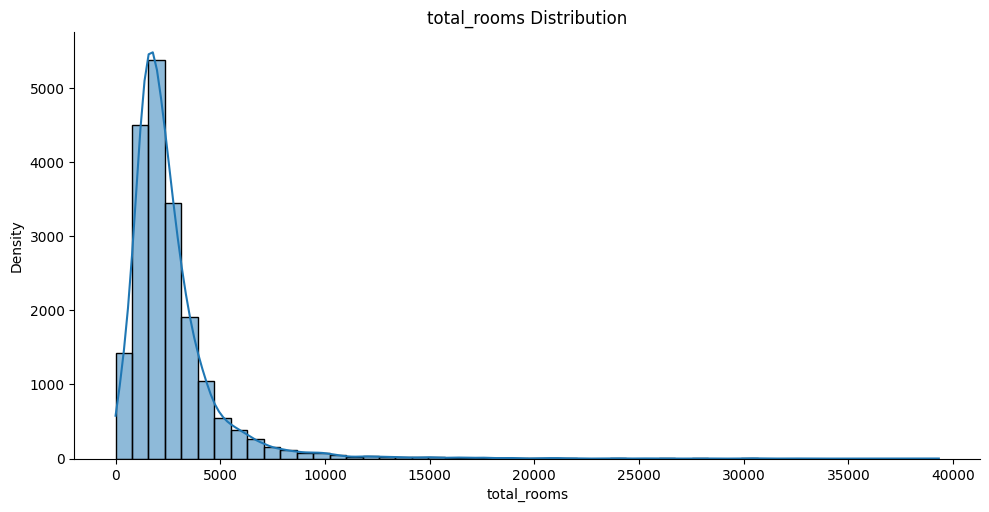

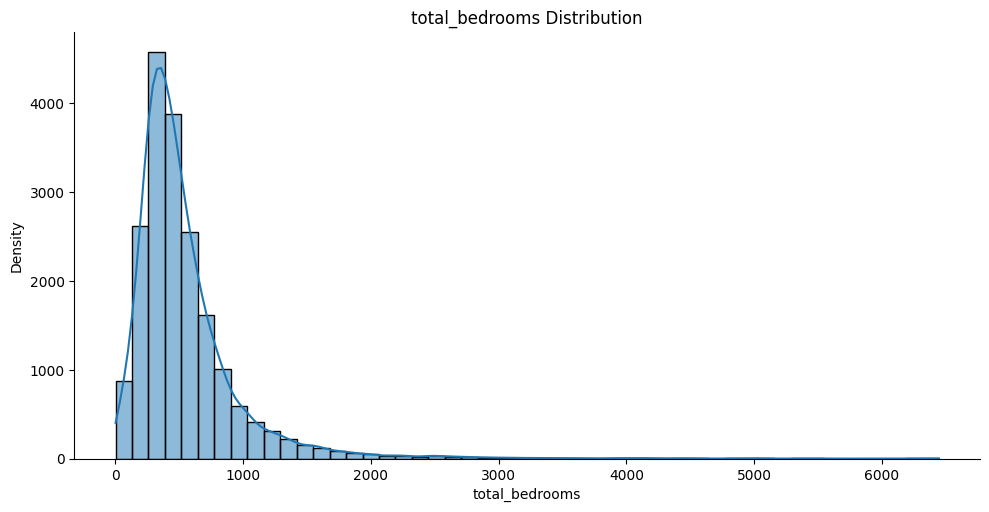

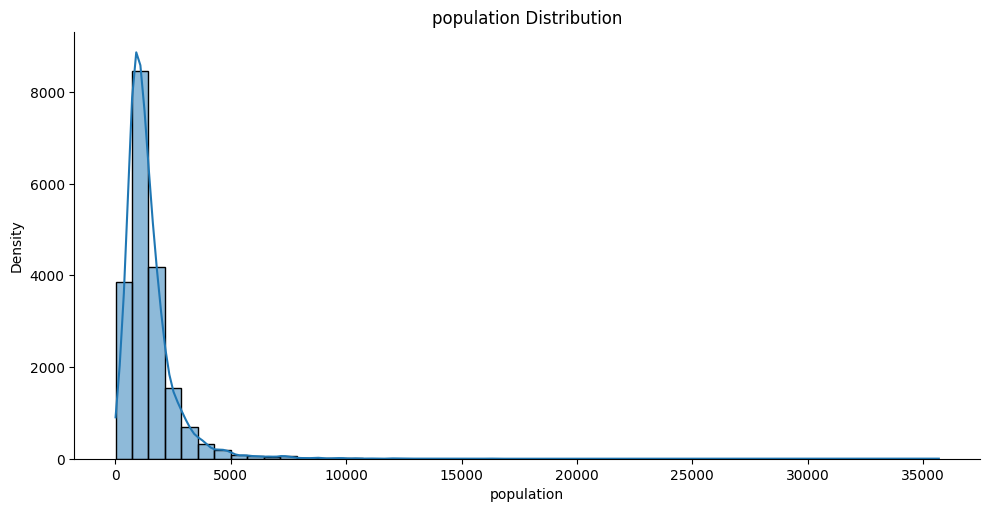

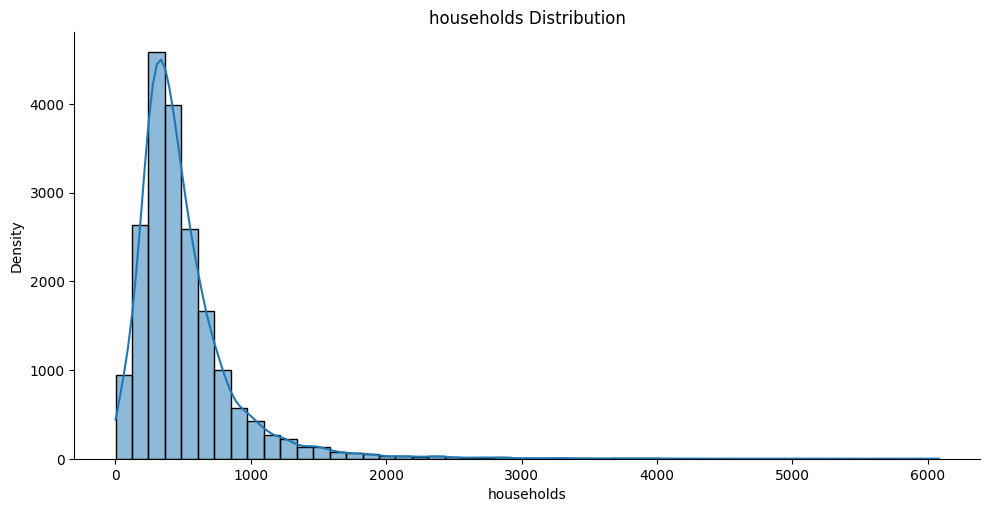

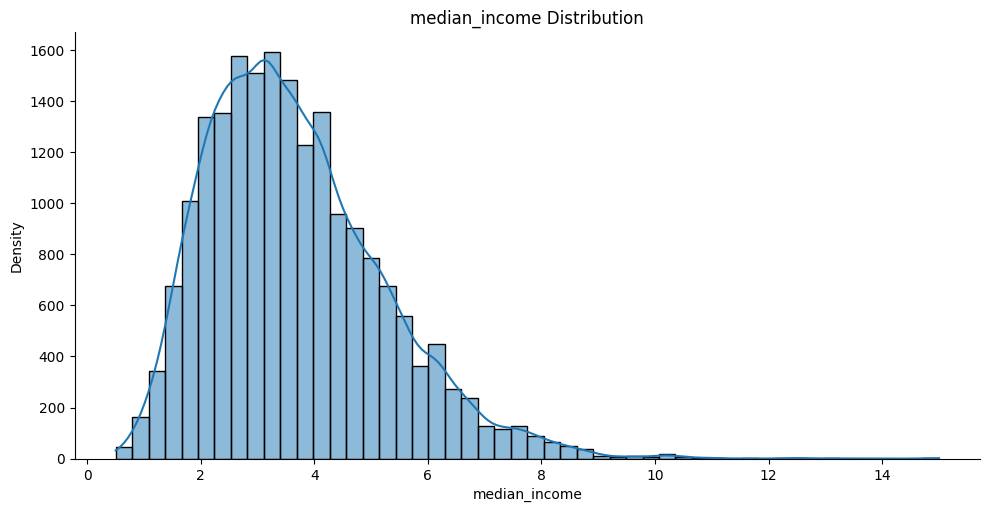

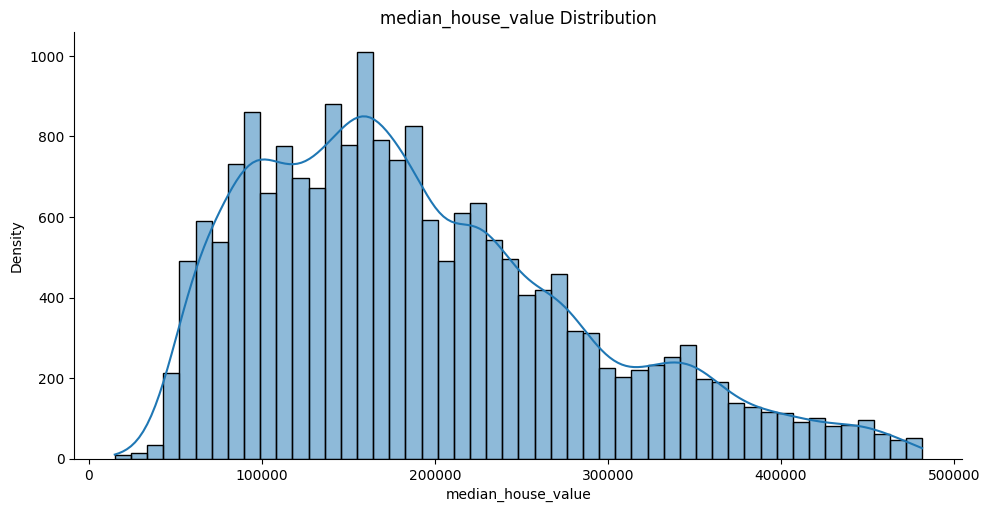

In [332]:
import matplotlib.pyplot as plt

# Filter numerical features with missing values
numerical_features_with_missing = [feature for feature in numerical_features if df[feature].isnull().any()]

for i, feature in enumerate(numerical_features_with_missing, start=1):
    sns.displot(df, x = feature, kde=True, bins=50, aspect=2)
    plt.title(feature + ' Distribution')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.show()



Features like "housing_median_age", "median_income" and "median house value" seem to have a relatively symmetric distribution, which might make mean imputation a reasonable choice.

Features such as "total_rooms," "total_bedrooms," "population," and "households" show a right-skewed distribution, suggesting that we should the median imputation to avoid the influence of outliers.

In [333]:
# Impute missing values for numerical features
for feature in numerical_features_with_missing:
    if feature in ['total_rooms', 'total_bedrooms', 'population', 'households']:
        df[feature].fillna(df[feature].median(), inplace=True)
    elif feature in ['housing_median_age', 'median_house_value']:
        df[feature].fillna(df[feature].mean(), inplace=True)


In [334]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           8
median_house_value      0
ocean_proximity       147
dtype: int64

In [335]:
# display the rows with missing values
df[df.isnull().any(axis=1)].head(10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
4323    -122.25     38.12           47.000000       1339.0           298.0  \
4328    -122.25     38.10           28.345912       1780.0           373.0   
4330    -122.34     37.97           28.345912        392.0           109.0   
4356    -122.35     37.95           28.345912       2449.0           595.0   
4361    -122.27     37.84           28.345912       1922.0           409.0   
4398    -122.22     38.10           28.345912       2256.0           451.0   
4409    -122.16     37.75           28.345912        617.0           131.0   
4418    -122.21     37.78           28.345912        881.0           248.0   
8028    -118.21     34.04           52.000000        846.0           271.0   
8029    -118.05     33.90           36.000000       1047.0           227.0   

      population  households  median_income  median_house_value   
4323      1181.0       286.0            NaN       109800.000000  \
4328      1181.0       317.0            NaN       109900.000000   
4330      1181.0        81.0            NaN       110000.000000   
4356      1181.0       548.0            NaN       110300.000000   
4361      1181.0       335.0            NaN       191276.395525   
4398      1181.0       426.0            NaN       191276.395525   
4409      1181.0       135.0            NaN       191276.395525   
4418      1181.0       241.0            NaN       191276.395525   
8028      1153.0       281.0         2.1923       155000.000000   
8029       975.0       239.0         3.1897       155000.000000   

     ocean_proximity  
4323        NEAR BAY  
4328        NEAR BAY  
4330        NEAR BAY  
4356        NEAR BAY  
4361        NEAR BAY  
4398        NEAR BAY  
4409        NEAR BAY  
4418        NEAR BAY  
8028             NaN  
8029             NaN

look for other ways to impute based on other categorical variables

For this section, we will use the categorical variable that we have, `ocean_proximity` to fill the missing values in the `median_income` feature.

In [336]:
grouped = df.groupby('ocean_proximity')
grouped

grouped_mean = grouped.mean()

grouped_mean

longitude   latitude  housing_median_age  total_rooms   
ocean_proximity                                                           
<1H OCEAN       -118.855592  34.574379           29.054874  2607.944890  \
INLAND          -119.738554  36.740622           24.248684  2721.052958   
ISLAND          -118.354000  33.358000           42.400000  1574.600000   
NEAR BAY        -122.254079  37.812054           37.100397  2501.777833   
NEAR OCEAN      -119.304067  34.715231           29.215621  2538.230162   
NEAR_bay        -122.246562  37.813125           40.750000  1154.437500   
inland          -119.549333  36.813333           30.933333  1368.000000   

                 total_bedrooms   population  households  median_income   
ocean_proximity                                                           
<1H OCEAN            548.176776  1546.175242  521.403115       3.991371  \
INLAND               534.487457  1394.150666  478.686281       3.185106   
ISLAND               420.400000   668.000000  276.600000       2.744420   
NEAR BAY             518.946305  1259.763054  494.549261       3.923584   
NEAR OCEAN           541.958870  1376.406315  505.754466       3.645862   
NEAR_bay             264.093750   739.343750  234.562500       2.046434   
inland               333.933333  1002.533333  289.733333       1.704287   

                 median_house_value  
ocean_proximity                      
<1H OCEAN             223352.048935  
INLAND                123139.371315  
ISLAND                380440.000000  
NEAR BAY              238185.142401  
NEAR OCEAN            225701.265448  
NEAR_bay               80043.750000  
inland                 48566.666667

We will use the mean value of the houses in the same `ocean_proximity` as our missing `median_income` row to fill the null value.

In [375]:
df['median_income'] = df['median_income'].fillna(grouped['median_income'].transform('mean'))

In [338]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity       147
dtype: int64

### For categorical features: Choose the appropriate imputation method. 

In [340]:
categorical_missing_values = df[categorical_features].isnull().sum()
categorical_missing_values

ocean_proximity    147
dtype: int64

In [341]:
ocean_proximity_distribution = df['ocean_proximity'].value_counts(normalize=True) * 100
ocean_proximity_distribution

ocean_proximity
<1H OCEAN     43.633181
INLAND        33.252665
NEAR OCEAN    12.393801
NEAR BAY      10.452603
NEAR_bay       0.164770
inland         0.077236
ISLAND         0.025745
Name: proportion, dtype: float64

For the categorical variable we will just use the mode to fill in the missing values.

In [342]:
# Impute missing values for the "ocean_proximity" categorical feature
most_frequent_category = df['ocean_proximity'].mode()[0]
df['ocean_proximity'].fillna(most_frequent_category, inplace=True)

In [343]:
categorical_missing_values = df[categorical_features].isnull().sum()
categorical_missing_values

ocean_proximity    0
dtype: int64

In [344]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Investigate the existence of errors/inconsistencies in the fields and solve them. 

Most of our features seem to be fine in terms of inconsistencies except the ocean_proximity as it is a categorical variable.

In [345]:
ocean_proximity_distribution = df['ocean_proximity'].value_counts(normalize=True) * 100
ocean_proximity_distribution

ocean_proximity
<1H OCEAN     44.056623
INLAND        33.002862
NEAR OCEAN    12.300695
NEAR BAY      10.374080
NEAR_bay       0.163532
inland         0.076656
ISLAND         0.025552
Name: proportion, dtype: float64

From the above, we can see that `INLAND` is represented in different ways, same as `NEAR BAY`. We will fix this below.

In [346]:
df['ocean_proximity'] = df['ocean_proximity'].str.upper().replace('NEAR_BAY', 'NEAR BAY').replace('INLAND', 'INLAND')

In [347]:
ocean_proximity_distribution = df['ocean_proximity'].value_counts(normalize=True) * 100
ocean_proximity_distribution

ocean_proximity
<1H OCEAN     44.056623
INLAND        33.079518
NEAR OCEAN    12.300695
NEAR BAY      10.537612
ISLAND         0.025552
Name: proportion, dtype: float64

## Normalize numerical features using appropriate method based on feature characteristics. 

<Figure size 1500x1000 with 0 Axes>

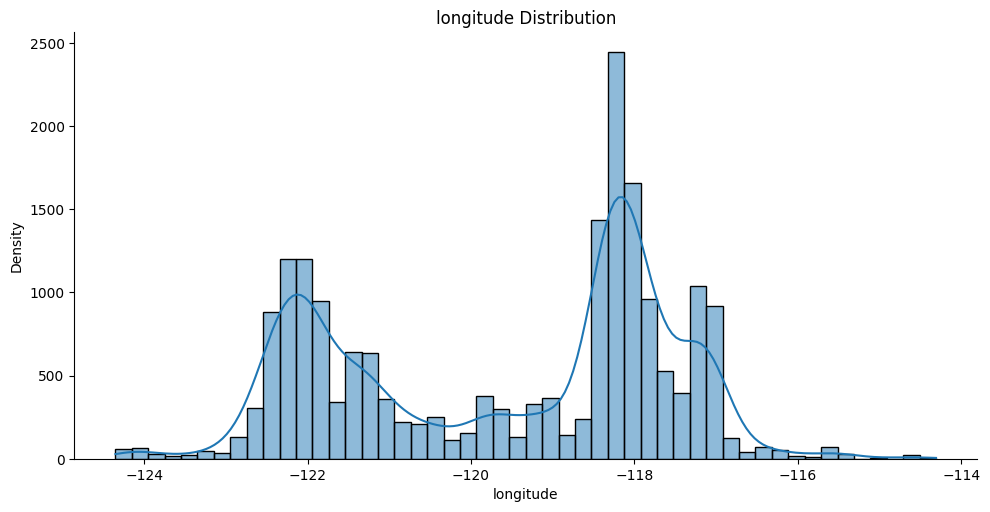

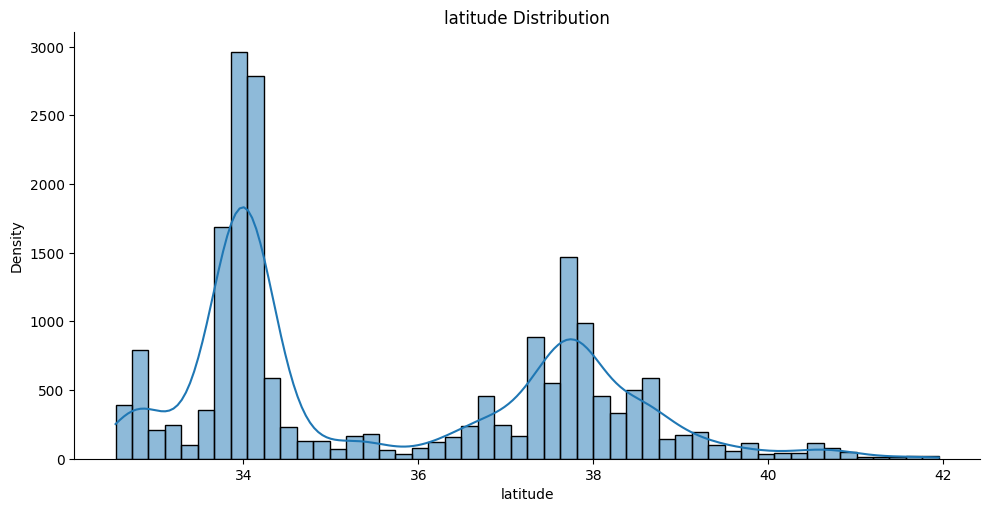

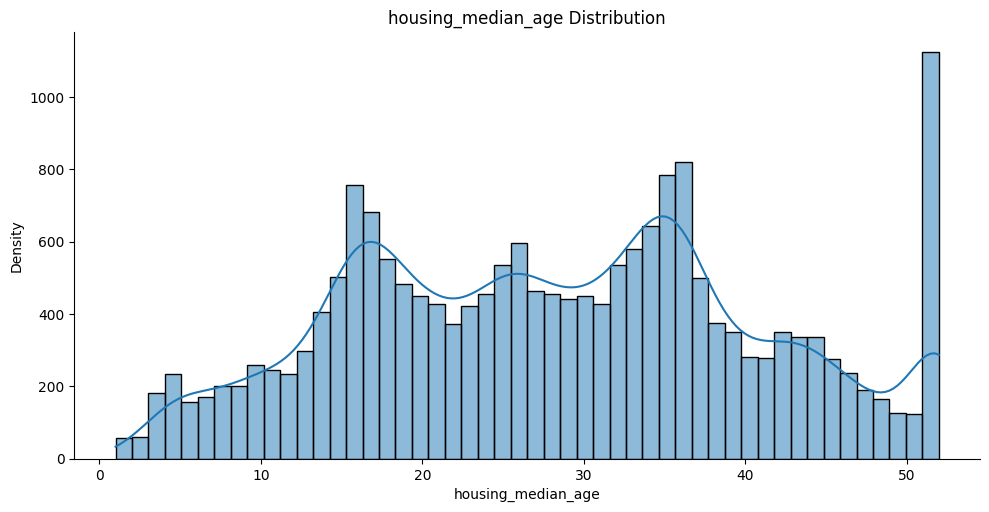

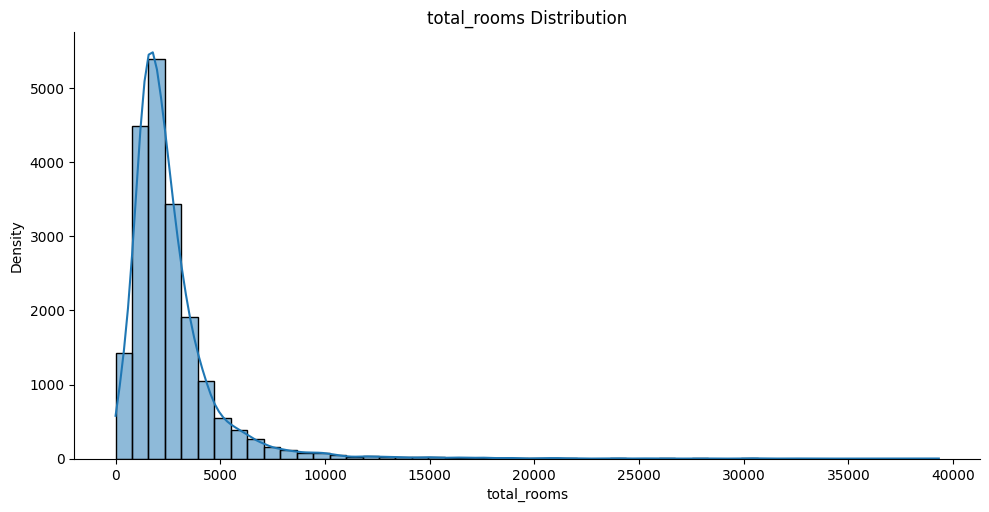

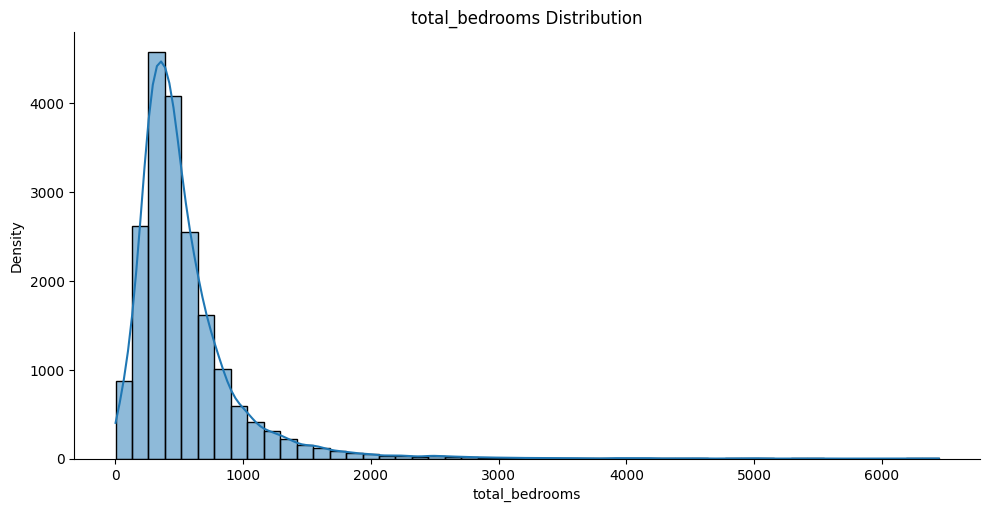

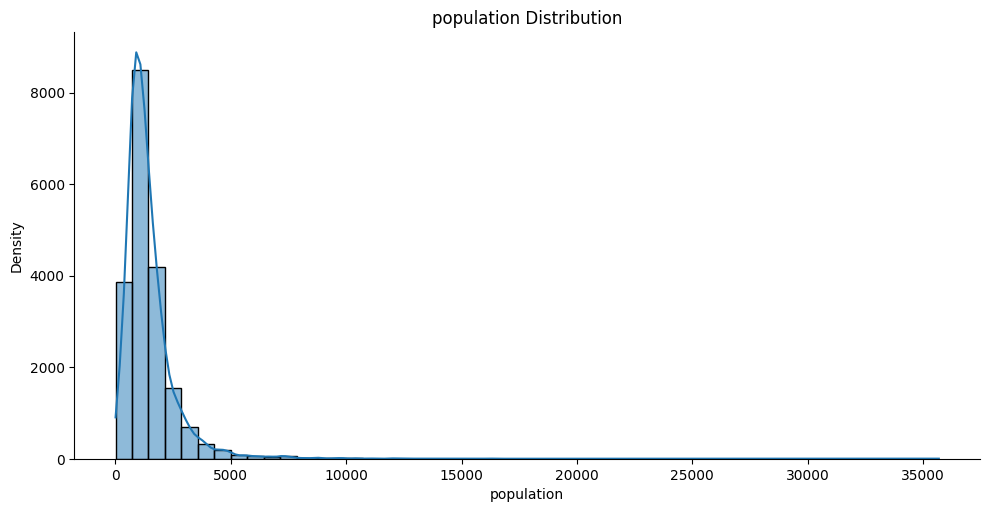

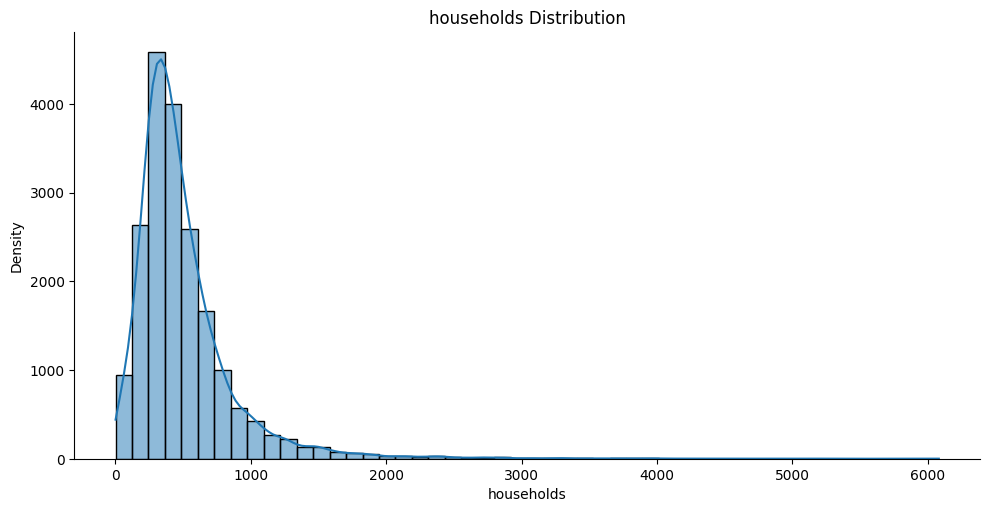

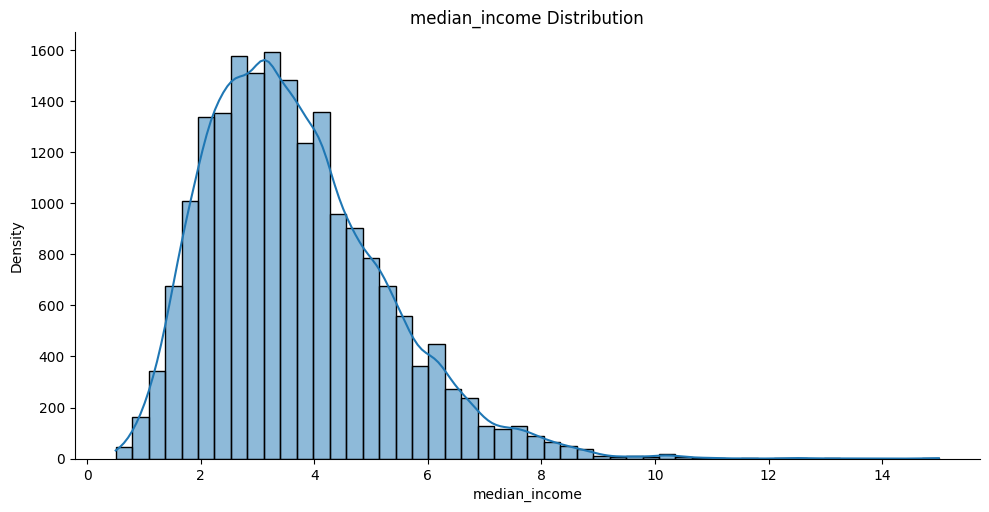

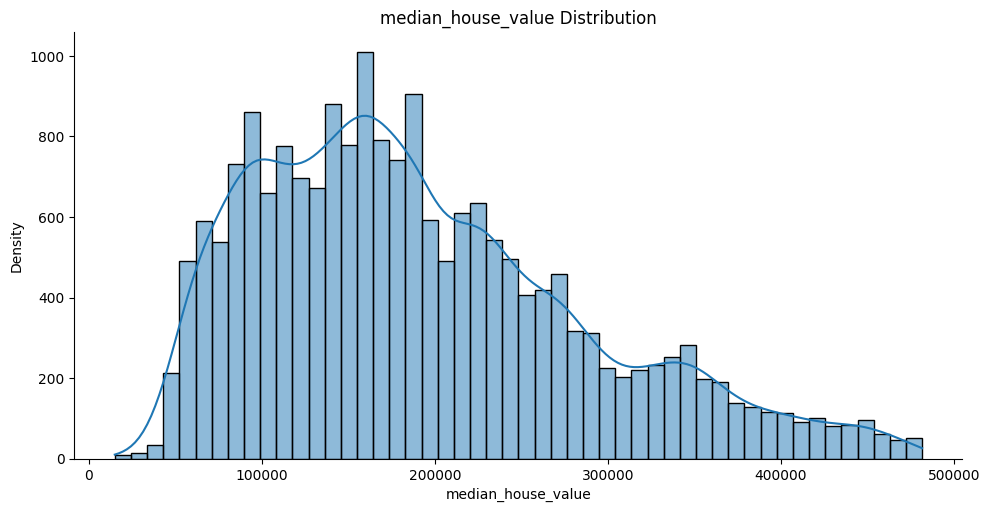

longitude      latitude  housing_median_age   total_rooms   
count  19568.000000  19568.000000        19568.000000  19568.000000  \
mean    -119.562847     35.654253           28.345912   2620.031224   
std        2.005797      2.151022           12.492858   2183.219609   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.760000     33.930000           18.000000   1438.000000   
50%     -118.510000     34.270000           28.000000   2110.000000   
75%     -117.990000     37.730000           37.000000   3122.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income   
count    19568.000000  19568.000000  19568.000000   19568.000000  \
mean       538.828904   1442.847404    501.462132       3.665777   
std        420.619024   1144.864976    383.351873       1.557565   
min          2.000000      3.000000      2.000000       0.499900   
25%        299.000000    798.000000    282.000000       2.523225   
50%        437.000000   1181.000000    411.000000       3.442650   
75%        645.000000   1749.000000    606.000000       4.571400   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        19568.000000  
mean        191276.395525  
std          95156.572728  
min          14999.000000  
25%         117300.000000  
50%         174000.000000  
75%         246700.000000  
max         481500.000000

In [348]:
# Review the summary statistics and histograms for numerical features to choose normalization methods
numerical_summary_updated = df[numerical_features].describe()

# Plot histograms for numerical features to visualize their distributions again
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, start=1):
    sns.displot(df, x = feature, kde=True, bins=50, aspect=2)
    plt.title(feature + ' Distribution')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.show()

numerical_summary_updated


As we already saw above, for features that seem to be normally distributed, we can use a standard scaler to scale the values but for features that shows a right (or left) skew, we will use the logarithmic approach.

In [349]:
from sklearn.preprocessing import StandardScaler
import numpy as np

df_normalized = df.copy()

scaler = StandardScaler()

# Features to apply standard scaling directly
standard_scaling_features = ['longitude', 'latitude', 'median_income']

# Features to apply log transformation followed by standard scaling
log_transform_features = ['total_rooms', 'total_bedrooms', 'population', 'households']

# Apply standard scaling
df_normalized[standard_scaling_features] = scaler.fit_transform(df_normalized[standard_scaling_features])

# Apply log transformation followed by standard scaling
df_normalized[log_transform_features] = np.log1p(df_normalized[log_transform_features])
df_normalized[log_transform_features] = scaler.fit_transform(df_normalized[log_transform_features])

# Display summary statistics of the transformed features to verify the changes
df_normalized[standard_scaling_features + log_transform_features].describe()


longitude      latitude  median_income   total_rooms   
count  1.956800e+04  1.956800e+04   1.956800e+04  1.956800e+04  \
mean   1.586085e-15  9.295735e-17  -4.647867e-17 -8.889046e-16   
std    1.000026e+00  1.000026e+00   1.000026e+00  1.000026e+00   
min   -2.386719e+00 -1.447839e+00  -2.032632e+00 -8.713342e+00   
25%   -1.095429e+00 -8.016179e-01  -7.335685e-01 -4.691609e-01   
50%    5.249154e-01 -6.435494e-01  -1.432571e-01  4.262155e-02   
75%    7.841705e-01  9.650297e-01   5.814502e-01  5.656476e-01   
max    2.618899e+00  2.926938e+00   7.277136e+00  3.948429e+00   

       total_bedrooms    population    households  
count    1.956800e+04  1.956800e+04  1.956800e+04  
mean    -1.371121e-15  1.539606e-16  3.485901e-17  
std      1.000026e+00  1.000026e+00  1.000026e+00  
min     -6.893148e+00 -7.698006e+00 -6.757728e+00  
25%     -4.948417e-01 -4.840097e-01 -4.757483e-01  
50%      3.094831e-02  4.930762e-02  4.315420e-02  
75%      5.708323e-01  5.837221e-01  5.785380e-01  
max      3.766971e+00  4.689886e+00  3.762782e+00

In [350]:
df_normalized

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0      -1.584025  1.885546                16.0    -2.774942       -2.439573  \
1       1.267781  0.346703                19.0    -1.593633       -0.804872   
2       0.848984 -0.657497                52.0    -1.246563       -0.651557   
3      -1.798410  2.164490                36.0    -4.043746       -3.741097   
4       0.614658 -0.699338                39.0    -1.897038       -1.292181   
...          ...       ...                 ...          ...             ...   
19563   0.938726 -0.996879                19.0     0.480909        0.002102   
19564  -1.374627  0.867399                17.0     1.574247        1.225724   
19565   0.704400 -0.843460                29.0     0.240968       -0.260961   
19566   0.579758 -0.820214                36.0     0.177307        0.008564   
19567   0.888870 -0.871354                 6.0     2.091959        1.525244   

       population  households  median_income  median_house_value   
0       -3.519670   -3.213953      -1.287348             14999.0  \
1       -1.147135   -1.221132      -1.005298             14999.0   
2       -0.809813   -0.786490       0.338629             14999.0   
3       -5.575992   -5.239868      -2.009455             14999.0   
4       -2.012970   -1.458040      -0.834064             17500.0   
...           ...         ...            ...                 ...   
19563    0.357345    0.105444       1.706055            480800.0   
19564    1.100707    1.313135       1.748558            480800.0   
19565   -0.329486   -0.182174       2.559717            481300.0   
19566   -0.132876    0.029675       1.904511            481500.0   
19567    1.619852    1.496955       4.176897            481500.0   

      ocean_proximity  
0              INLAND  
1              INLAND  
2              INLAND  
3              INLAND  
4           <1H OCEAN  
...               ...  
19563       <1H OCEAN  
19564      NEAR OCEAN  
19565       <1H OCEAN  
19566       <1H OCEAN  
19567       <1H OCEAN  

[19568 rows x 10 columns]

## Encode categorical variables using using appropriate method based on feature characteristics. 

In [351]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first') 

ocean_proximity_encoded = encoder.fit_transform(df_normalized[['ocean_proximity']])

ocean_proximity_encoded_df = pd.DataFrame(ocean_proximity_encoded, columns=encoder.get_feature_names_out(['ocean_proximity']))

df_encoded_and_normalized = pd.concat([df_normalized.drop('ocean_proximity', axis=1), ocean_proximity_encoded_df], axis=1)

df_encoded_and_normalized.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0  -1.584025  1.885546                16.0    -2.774942       -2.439573  \
1   1.267781  0.346703                19.0    -1.593633       -0.804872   
2   0.848984 -0.657497                52.0    -1.246563       -0.651557   
3  -1.798410  2.164490                36.0    -4.043746       -3.741097   
4   0.614658 -0.699338                39.0    -1.897038       -1.292181   

   population  households  median_income  median_house_value   
0   -3.519670   -3.213953      -1.287348             14999.0  \
1   -1.147135   -1.221132      -1.005298             14999.0   
2   -0.809813   -0.786490       0.338629             14999.0   
3   -5.575992   -5.239868      -2.009455             14999.0   
4   -2.012970   -1.458040      -0.834064             17500.0   

   ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_NEAR BAY   
0                     1.0                     0.0                       0.0  \
1                     1.0                     0.0                       0.0   
2                     1.0                     0.0                       0.0   
3                     1.0                     0.0                       0.0   
4                     0.0                     0.0                       0.0   

   ocean_proximity_NEAR OCEAN  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0

##  Engineer one new feature based on existing features. 

In [352]:
df_encoded_and_normalized['rooms_per_household'] = df['total_rooms'] / df['households']

#we use log transformation to reduce the skewness of the 'rooms_per_household' feature and for completeness, apply standard scaling
df_encoded_and_normalized['rooms_per_household'] = np.log1p(df_encoded_and_normalized['rooms_per_household'])
df_encoded_and_normalized['rooms_per_household'] = scaler.fit_transform(df_encoded_and_normalized[['rooms_per_household']])

df_encoded_and_normalized

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0      -1.584025  1.885546                16.0    -2.774942       -2.439573  \
1       1.267781  0.346703                19.0    -1.593633       -0.804872   
2       0.848984 -0.657497                52.0    -1.246563       -0.651557   
3      -1.798410  2.164490                36.0    -4.043746       -3.741097   
4       0.614658 -0.699338                39.0    -1.897038       -1.292181   
...          ...       ...                 ...          ...             ...   
19563   0.938726 -0.996879                19.0     0.480909        0.002102   
19564  -1.374627  0.867399                17.0     1.574247        1.225724   
19565   0.704400 -0.843460                29.0     0.240968       -0.260961   
19566   0.579758 -0.820214                36.0     0.177307        0.008564   
19567   0.888870 -0.871354                 6.0     2.091959        1.525244   

       population  households  median_income  median_house_value   
0       -3.519670   -3.213953      -1.287348             14999.0  \
1       -1.147135   -1.221132      -1.005298             14999.0   
2       -0.809813   -0.786490       0.338629             14999.0   
3       -5.575992   -5.239868      -2.009455             14999.0   
4       -2.012970   -1.458040      -0.834064             17500.0   
...           ...         ...            ...                 ...   
19563    0.357345    0.105444       1.706055            480800.0   
19564    1.100707    1.313135       1.748558            480800.0   
19565   -0.329486   -0.182174       2.559717            481300.0   
19566   -0.132876    0.029675       1.904511            481500.0   
19567    1.619852    1.496955       4.176897            481500.0   

       ocean_proximity_INLAND  ocean_proximity_ISLAND   
0                         1.0                     0.0  \
1                         1.0                     0.0   
2                         1.0                     0.0   
3                         1.0                     0.0   
4                         0.0                     0.0   
...                       ...                     ...   
19563                     0.0                     0.0   
19564                     0.0                     0.0   
19565                     0.0                     0.0   
19566                     0.0                     0.0   
19567                     0.0                     0.0   

       ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN   
0                           0.0                         0.0  \
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
...                         ...                         ...   
19563                       0.0                         0.0   
19564                       0.0                         1.0   
19565                       0.0                         0.0   
19566                       0.0                         0.0   
19567                       0.0                         0.0   

       rooms_per_household  
0                 0.984397  
1                -1.125329  
2                -1.318978  
3                 3.367416  
4                -1.315535  
...                    ...  
19563             1.043045  
19564             0.826576  
19565             1.154490  
19566             0.388780  
19567             1.811889  

[19568 rows x 14 columns]

# Descriptive Analytics Tasks

## Investigate the distribution of housing prices across different ocean proximities in California. 

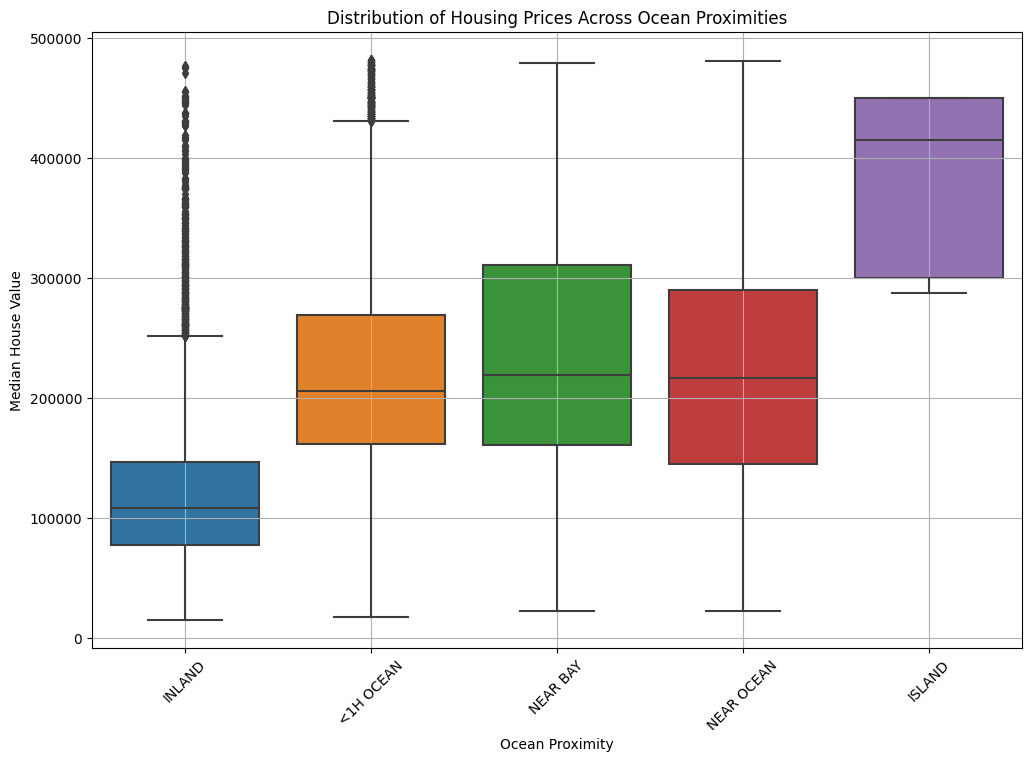

In [353]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df)

plt.title('Distribution of Housing Prices Across Ocean Proximities')
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Analyze the relationship between median income and housing prices. 

In [354]:
fig = px.scatter(df, x='median_income', y='median_house_value', title='Relationship Between Median Income and Housing Prices')
fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig.show()


In this graph, I can see that there is a degree of direct variation between these two axis, as the value of the median income increases, so does the value of the house. Which makes sense, because typically, on average, the more money a household earns, the more expensive their house will be and vice versa.


There appears to be a positive correlation between median income and median house value, indicating that as median income increases, the median house value also tends to increase. This relationship is expected as higher-income households can afford more expensive homes.
The plot shows a concentration of data points at lower income levels with a wide range of housing prices, suggesting that other factors besides income may also significantly influence housing prices.

# ML Model Training and Testing Tasks

## Split the cleaned data from the first section into training and testing sets (e.g., 80% training, 20% testing). 

In [355]:
cleaned_df = df_encoded_and_normalized.copy()

In [356]:
X = cleaned_df.drop('median_house_value', axis=1)
y = cleaned_df['median_house_value']

In [357]:
X

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0      -1.584025  1.885546                16.0    -2.774942       -2.439573  \
1       1.267781  0.346703                19.0    -1.593633       -0.804872   
2       0.848984 -0.657497                52.0    -1.246563       -0.651557   
3      -1.798410  2.164490                36.0    -4.043746       -3.741097   
4       0.614658 -0.699338                39.0    -1.897038       -1.292181   
...          ...       ...                 ...          ...             ...   
19563   0.938726 -0.996879                19.0     0.480909        0.002102   
19564  -1.374627  0.867399                17.0     1.574247        1.225724   
19565   0.704400 -0.843460                29.0     0.240968       -0.260961   
19566   0.579758 -0.820214                36.0     0.177307        0.008564   
19567   0.888870 -0.871354                 6.0     2.091959        1.525244   

       population  households  median_income  ocean_proximity_INLAND   
0       -3.519670   -3.213953      -1.287348                     1.0  \
1       -1.147135   -1.221132      -1.005298                     1.0   
2       -0.809813   -0.786490       0.338629                     1.0   
3       -5.575992   -5.239868      -2.009455                     1.0   
4       -2.012970   -1.458040      -0.834064                     0.0   
...           ...         ...            ...                     ...   
19563    0.357345    0.105444       1.706055                     0.0   
19564    1.100707    1.313135       1.748558                     0.0   
19565   -0.329486   -0.182174       2.559717                     0.0   
19566   -0.132876    0.029675       1.904511                     0.0   
19567    1.619852    1.496955       4.176897                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY   
0                         0.0                       0.0  \
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   
...                       ...                       ...   
19563                     0.0                       0.0   
19564                     0.0                       0.0   
19565                     0.0                       0.0   
19566                     0.0                       0.0   
19567                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  rooms_per_household  
0                             0.0             0.984397  
1                             0.0            -1.125329  
2                             0.0            -1.318978  
3                             0.0             3.367416  
4                             0.0            -1.315535  
...                           ...                  ...  
19563                         0.0             1.043045  
19564                         1.0             0.826576  
19565                         0.0             1.154490  
19566                         0.0             0.388780  
19567                         0.0             1.811889  

[19568 rows x 13 columns]

In [358]:
X.describe()

longitude      latitude  housing_median_age   total_rooms   
count  1.956800e+04  1.956800e+04        19568.000000  1.956800e+04  \
mean   1.586085e-15  9.295735e-17           28.345912 -8.889046e-16   
std    1.000026e+00  1.000026e+00           12.492858  1.000026e+00   
min   -2.386719e+00 -1.447839e+00            1.000000 -8.713342e+00   
25%   -1.095429e+00 -8.016179e-01           18.000000 -4.691609e-01   
50%    5.249154e-01 -6.435494e-01           28.000000  4.262155e-02   
75%    7.841705e-01  9.650297e-01           37.000000  5.656476e-01   
max    2.618899e+00  2.926938e+00           52.000000  3.948429e+00   

       total_bedrooms    population    households  median_income   
count    1.956800e+04  1.956800e+04  1.956800e+04   1.956800e+04  \
mean    -1.371121e-15  1.539606e-16  3.485901e-17  -4.647867e-17   
std      1.000026e+00  1.000026e+00  1.000026e+00   1.000026e+00   
min     -6.893148e+00 -7.698006e+00 -6.757728e+00  -2.032632e+00   
25%     -4.948417e-01 -4.840097e-01 -4.757483e-01  -7.335685e-01   
50%      3.094831e-02  4.930762e-02  4.315420e-02  -1.432571e-01   
75%      5.708323e-01  5.837221e-01  5.785380e-01   5.814502e-01   
max      3.766971e+00  4.689886e+00  3.762782e+00   7.277136e+00   

       ocean_proximity_INLAND  ocean_proximity_ISLAND   
count            19568.000000            19568.000000  \
mean                 0.330795                0.000256   
std                  0.470511                0.015983   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  1.000000                0.000000   
max                  1.000000                1.000000   

       ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN   
count              19568.000000                19568.000000  \
mean                   0.105376                    0.123007   
std                    0.307045                    0.328454   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.000000                    0.000000   
max                    1.000000                    1.000000   

       rooms_per_household  
count         1.956800e+04  
mean          5.461244e-16  
std           1.000026e+00  
min          -5.988485e+00  
25%          -5.727983e-01  
50%           1.178097e-02  
75%           5.370466e-01  
max           1.353643e+01

In [359]:
y

0         14999.0
1         14999.0
2         14999.0
3         14999.0
4         17500.0
           ...   
19563    480800.0
19564    480800.0
19565    481300.0
19566    481500.0
19567    481500.0
Name: median_house_value, Length: 19568, dtype: float64

## Split the data into training and testing sets

In [360]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15654, 13), (3914, 13), (15654,), (3914,))

##  Implement the closed-form solution to linear regression:
-   `𝜃=(𝑋𝑇𝑋)−1𝑋𝑇𝑦`

## where 𝜃 is the vector of weights (including the bias (𝑏)), 𝑋 is the feature matrix with a column of ones added to represent the intercept, and 𝑦 is the vector of target values.

In [361]:
# 1. Add intercept term to X_train
X_train_with_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

# 2. Apply the Normal Equation
theta = np.linalg.inv(X_train_with_intercept.T.dot(X_train_with_intercept)).dot(X_train_with_intercept.T).dot(y_train)

### Use your implementation to compute the coefficients for your linear regression model on the training dataset split.

In [362]:
theta

array([ 178513.34790232,  -52416.36635593,  -52593.66934311,
           873.98465428, -254128.97809724,   34584.42854853,
        -52670.25837836,  270402.99822062,   61101.21090688,
        -33801.74416274,  182153.7745946 ,   -8912.93676578,
           774.77918227,   83267.26523061])

## Print the learned coefficients (weights) of the model. 

In [363]:
for i, coef in enumerate(theta[1:], start=1):
    print(f'Coefficient for feature {X.columns[i-1]}: {coef:.4f}')
    
print(f'Intercept: {theta[0]:.4f}')

Coefficient for feature longitude: -52416.3664
Coefficient for feature latitude: -52593.6693
Coefficient for feature housing_median_age: 873.9847
Coefficient for feature total_rooms: -254128.9781
Coefficient for feature total_bedrooms: 34584.4285
Coefficient for feature population: -52670.2584
Coefficient for feature households: 270402.9982
Coefficient for feature median_income: 61101.2109
Coefficient for feature ocean_proximity_INLAND: -33801.7442
Coefficient for feature ocean_proximity_ISLAND: 182153.7746
Coefficient for feature ocean_proximity_NEAR BAY: -8912.9368
Coefficient for feature ocean_proximity_NEAR OCEAN: 774.7792
Coefficient for feature rooms_per_household: 83267.2652
Intercept: 178513.3479


In [364]:
print('y = ', end='')
for i, coef in enumerate(theta[1:], start=1):
    print(f'{coef:.4f} * {X.columns[i-1]} + ', end='')
print(f'{theta[0]:.4f}')


y = -52416.3664 * longitude + -52593.6693 * latitude + 873.9847 * housing_median_age + -254128.9781 * total_rooms + 34584.4285 * total_bedrooms + -52670.2584 * population + 270402.9982 * households + 61101.2109 * median_income + -33801.7442 * ocean_proximity_INLAND + 182153.7746 * ocean_proximity_ISLAND + -8912.9368 * ocean_proximity_NEAR BAY + 774.7792 * ocean_proximity_NEAR OCEAN + 83267.2652 * rooms_per_household + 178513.3479


### Comment on which feature the model gave higher weight to in the weight vector

In [365]:
# feature with the highest coefficient
max_coef_feature = X.columns[np.argmax(np.abs(theta[1:]))]
max_coef_feature

'households'

The model gave the newly engineered `households` feature the most weight.

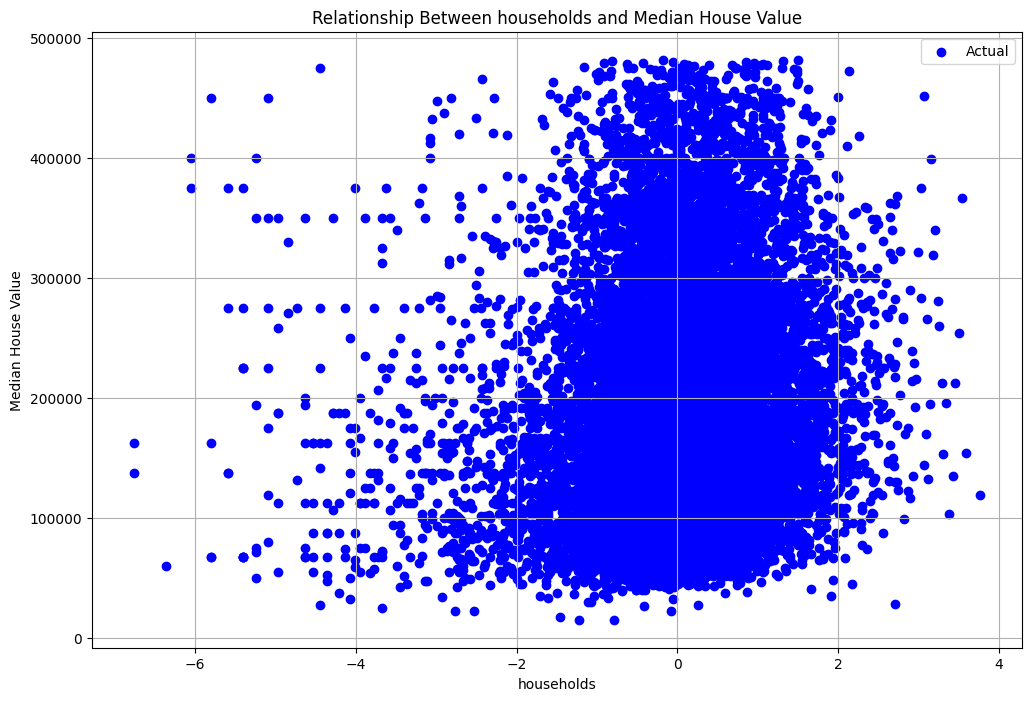

In [366]:
# scatter plot of the feature with the highest coefficient against the target variable
plt.figure(figsize=(12, 8))
plt.scatter(X_train[max_coef_feature], y_train, color='blue', label='Actual')
plt.xlabel(max_coef_feature)
plt.ylabel('Median House Value')
plt.title(f'Relationship Between {max_coef_feature} and Median House Value')
plt.legend()
plt.grid(True)
plt.show()


## Utilize the learned coefficients to generate predictions on the test dataset split, where:  𝑦̂=𝑋𝜃 

In [367]:
# Step 1: Prepare the feature matrix for X_test by adding a column of ones for the intercept
X_test_with_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Step 2: Calculate predictions using matrix multiplication
y_pred = X_test_with_intercept.dot(theta)

y_pred

array([145044.1722121 , 206513.58904929, 213779.30064989, ...,
        93588.97512634,  93096.14578398, 158291.45929641])

## Implement the following evaluation metrics using NumPy functions only

### Mean Absolute Error (MAE)

In [368]:
def mean_absolute_error(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae


### Mean Squared Error (MSE)

In [369]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean(np.square(y_true - y_pred))
    return mse

## Evaluate the model's performance on the test set using the implemented metrics and report your results. 

In [370]:
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 41642.124256725096


In [371]:
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 3254689701.227839


### Comment on the models performance.

The model performed relatively well compared to other linear regression models that I have used with this housing dataset. 

##  Is there an additional metric to be used to give a more intuitive measurement of the model’s performance, if yes please implement it from scratch and report the performance of your model with a comment on it. 

We can use the R square score to measure our model's performance.

In [372]:
def r_squared(y_true, y_pred):
    ss_res = np.sum(np.square(y_true - y_pred))  # Sum of squares of residuals
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

# Assuming y_test contains the actual values and y_pred contains your model predictions
r2_score = r_squared(y_test, y_pred)


In [373]:
r2_score

0.639742149536205

r2 scores are usually between 0 and 1, the closer the score is to 1, the better the model performed giving its features.

Our model has a score of 0.64, which is more than 0.5 so this is a good performance by the model.